## Investigating issue with fixed target data in `st_yellow` stream

<script src="https://cdn.jsdelivr.net/gh/plexoos/pub-docs@0be43f5/assets/ipynb.js"></script>
 
<a id="toggle_all_input" href="#" data-show-input="false" onclick="toggleAllInput(this); return false;">Show/Hide input</a>

In [1]:
import collections
import fnmatch
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pprint

import star.utils as stu
import star.phys as phys
import star.track as track

### The issue

There is a concern that the offline event reconstruction does not see vertices in the yellow stream data
despite seeing normal behavior in the physics and zerobias data streams.

### The data

We analyze the data taken during 14 fixed target runs on day 226 of 2020.
Currently, consider runs 21226026 and 21226035.
The original raw data DAQ files for the three streams (`st_physics`, `st_zerobias`, and `st_yellow`)
are available from the following locations:
 
    /star/data03/daq/2020/226/21226026/
    /star/data03/daq/2020/226/21226035/

with the files matching glob expressions such as:

    st_zerobias_*_21226026_*.daq
    st_physics_*_21226026_*.daq
    st_zerobias_*_21226035_*.daq
 
The following MuDst files were produced by Ben K. and copied to a local machine

In [2]:
prefix = '/Users/dsmirnov/work/pub-docs/star-fxt-issue'

runs     = {'r26': '21226026', 'r35': '21226035'}
streams  = {'ph': 'st_physics', 'zb': 'st_zerobias', 'ye': 'st_yellow'}

Tag = collections.namedtuple('Tag', ['run','stream', 'run_name', 'stream_name'])

def get_tags(runs, streams):
    tags = []
    for r, rv in runs.items():
        for s, sv in streams.items():
            tags.append(Tag(r, s, rv, sv))
    return tags

def get_mudst_files(tags):
    rootfiles  = {}
    for tag in tags:
        run = runs[tag.run]
        stream = streams[tag.stream]
        rootfiles[tag] = [os.path.join(dirpath, f) for dirpath, dirnames, files in os.walk(f'{prefix}/run_{run}/{stream}')
                                                   for f in fnmatch.filter(files, '*.MuDst.root')]
    return rootfiles

tags = get_tags(runs, streams)
rootfiles = get_mudst_files(tags) 

#pprint.pprint(rootfiles)

Preparing dataframes with interesting variables from the MuDst files does not take long 

First select track parameters saved in the MuDst files

In [3]:
branches_trk = {
    'px':    'GlobalTracks.mP.mX1',
    'py':    'GlobalTracks.mP.mX2',
    'pz':    'GlobalTracks.mP.mX3',
    'gpt':   'GlobalTracks.mPt',
    'dcax':  'GlobalTracks.mDCA.mX1',
    'dcay':  'GlobalTracks.mDCA.mX2',
    'dcaz':  'GlobalTracks.mDCA.mX3',
    'dcaxg': 'GlobalTracks.mDCAGlobal.mX1',
    'dcayg': 'GlobalTracks.mDCAGlobal.mX2',
    'dcazg': 'GlobalTracks.mDCAGlobal.mX3',
    'q':     'GlobalTracks.mHelix.mQ',
    'B':     'GlobalTracks.mHelix.mB',
    'hx':    'GlobalTracks.mHelix.mOrigin.mX1',
    'hy':    'GlobalTracks.mHelix.mOrigin.mX2',
    'hz':    'GlobalTracks.mHelix.mOrigin.mX3',
    'hpx':   'GlobalTracks.mHelix.mP.mX1',
    'hpy':   'GlobalTracks.mHelix.mP.mX2',
    'hpz':   'GlobalTracks.mHelix.mP.mX3',
    'ohx':   'GlobalTracks.mOuterHelix.mOrigin.mX1',
    'ohy':   'GlobalTracks.mOuterHelix.mOrigin.mX2',
    'ohz':   'GlobalTracks.mOuterHelix.mOrigin.mX3',
    'ohpx':  'GlobalTracks.mOuterHelix.mP.mX1',
    'ohpy':  'GlobalTracks.mOuterHelix.mP.mX2',
    'ohpz':  'GlobalTracks.mOuterHelix.mP.mX3',
}

In [4]:
%%time

def make_df(rootfiles, branches):
    df, _ = stu.make_df(rootfiles, 'MuDst', branches, {})
    return df
    
dfs = { tag: make_df(rootfiles_, branches_trk) for tag, rootfiles_ in rootfiles.items()}

CPU times: user 24.6 s, sys: 635 ms, total: 25.2 s
Wall time: 26.5 s


In [5]:
dfs = { tag: stu.add_track_params(df) for tag, df in dfs.items()}

#dfs.keys()
#df_ph, df_zb, df_ye = dfs.values()
#[df.info() for df in dfs.values()]

Then select vertex parameters saved in the MuDst files

In [6]:
branches_vtx = {
    'vx':   'PrimaryVertices.mPosition.mX1',
    'vy':   'PrimaryVertices.mPosition.mX2',
    'vz':   'PrimaryVertices.mPosition.mX3',
}

In [7]:
%%time
dfvs = { tag: make_df(rootfiles_, branches_vtx) for tag, rootfiles_ in rootfiles.items()}

CPU times: user 21.9 s, sys: 115 ms, total: 22 s
Wall time: 22.3 s


In [8]:
#dfv_ph, dfv_zb, dfv_ye = dfvs.values()
#[df.info() for df in dfvs.values()]

### Initial look at the total counts

The total event and track counts in the reconstructed MuDst files for each of the streams are: 

In [9]:
print(f'{"run": >6}  {"stream": >6}  {"events": >9}  {"tracks": >9}')

for tag, df in dfs.items():
    n_tracks_per_event = df.groupby(level=['file', 'entry']).size()
    n_events = len(n_tracks_per_event)
    n_tracks = np.sum(n_tracks_per_event)
    print(f'{tag.run: >6}  {tag.stream: >6}  {n_events: >9}  {n_tracks: >9}')

   run  stream     events     tracks
   r26      ph        935     315077
   r26      zb       1017      56163
   r26      ye       3204     314870
   r35      ph        913     294840
   r35      zb        427      18894
   r35      ye       3575     316523


In [10]:
class PtCut:
    def __init__(self, min_pt): self.min_pt = math.nan if min_pt is None else min_pt
    def indexer(self, df): return df.pt > self.min_pt if not np.isnan(self.min_pt) else df.pt.notna()

pt_cuts = [
    PtCut(None),
    PtCut(0),
    PtCut(0.1),
    PtCut(0.2),
    PtCut(0.3),
    PtCut(0.4),
    PtCut(0.5),
    PtCut(1)
]

Now let's see what fraction of tracks has $P_T$ higher than a certain value.
The four columns below show

    <run>  <stream>  <min $P_T$ in GeV>  <num. tracks passed the cut>  <relative fraction of tracks>

In [11]:
def get_pt_indexers(dfs):
    totals = {}
    
    for tag, df in dfs.items():
        for cut in pt_cuts:
            if math.isnan(cut.min_pt):
                totals[tag] = np.count_nonzero(cut.indexer(df))
    
    pt_indexers = {}
    
    for tag, df in dfs.items():
        for cut in pt_cuts:
            indexer = cut.indexer(df)
            pt_indexers.setdefault(tag, []).append(indexer)
            nonzeros = np.count_nonzero(indexer)
            noz_frac = nonzeros / totals[tag] * 100
            print( f'Run {tag.run_name: <10} {tag.stream_name: <6} {cut.min_pt:4.1f} {nonzeros: >8} {noz_frac:8.2f}%' )
        print()    
    return pt_indexers

In [12]:
pt_indexers = get_pt_indexers(dfs)

Run 21226026   st_physics  nan   315077   100.00%
Run 21226026   st_physics  0.0   313691    99.56%
Run 21226026   st_physics  0.1   233085    73.98%
Run 21226026   st_physics  0.2   164801    52.30%
Run 21226026   st_physics  0.3   120057    38.10%
Run 21226026   st_physics  0.4    86736    27.53%
Run 21226026   st_physics  0.5    62646    19.88%
Run 21226026   st_physics  1.0    14230     4.52%

Run 21226026   st_zerobias  nan    56163   100.00%
Run 21226026   st_zerobias  0.0    48994    87.24%
Run 21226026   st_zerobias  0.1    36586    65.14%
Run 21226026   st_zerobias  0.2    26233    46.71%
Run 21226026   st_zerobias  0.3    19098    34.00%
Run 21226026   st_zerobias  0.4    13653    24.31%
Run 21226026   st_zerobias  0.5     9637    17.16%
Run 21226026   st_zerobias  1.0     2176     3.87%

Run 21226026   st_yellow  nan   314870   100.00%
Run 21226026   st_yellow  0.0   257792    81.87%
Run 21226026   st_yellow  0.1   189720    60.25%
Run 21226026   st_yellow  0.2   134081    4

### Plots illustrating the issue

Do we have the DCA information saved in the MuDst files?

Remember, the DCA values save in the MuDst are given relative to a vertex.

The plots below do show that the DCA is missing from the `st_yellow` files

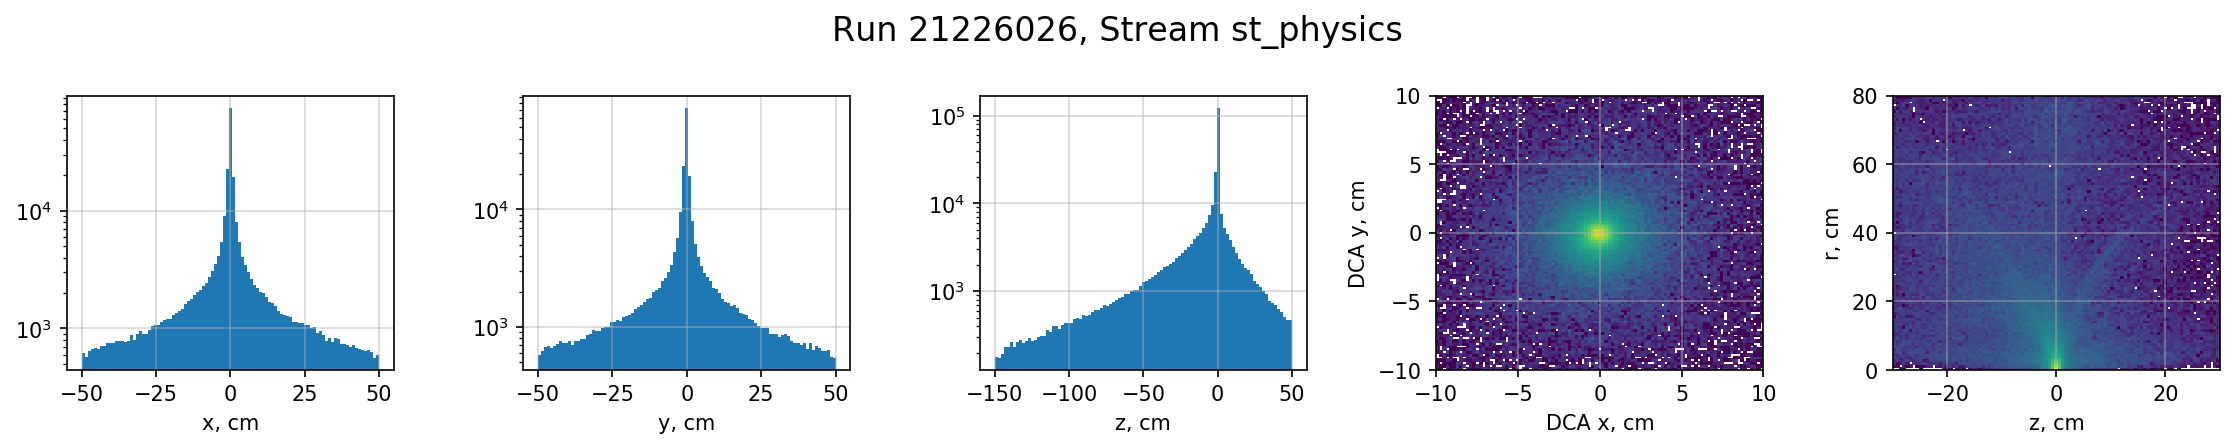

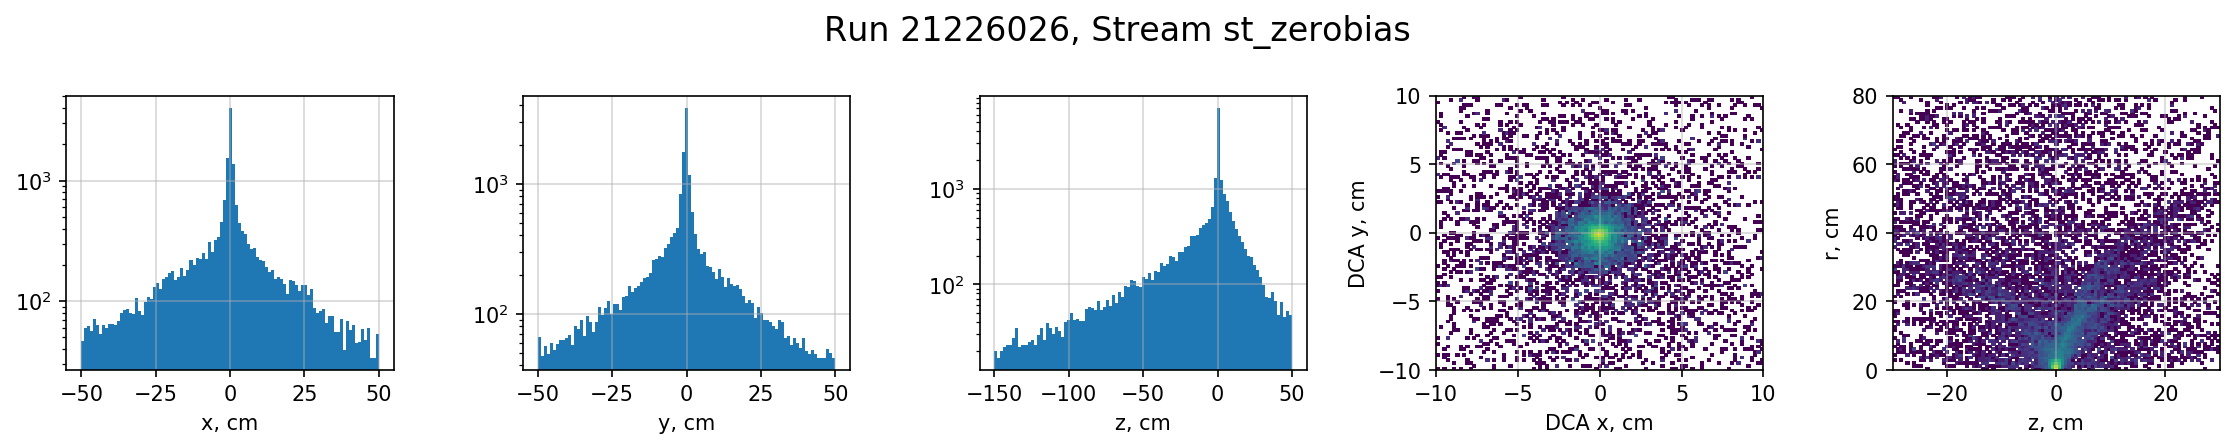

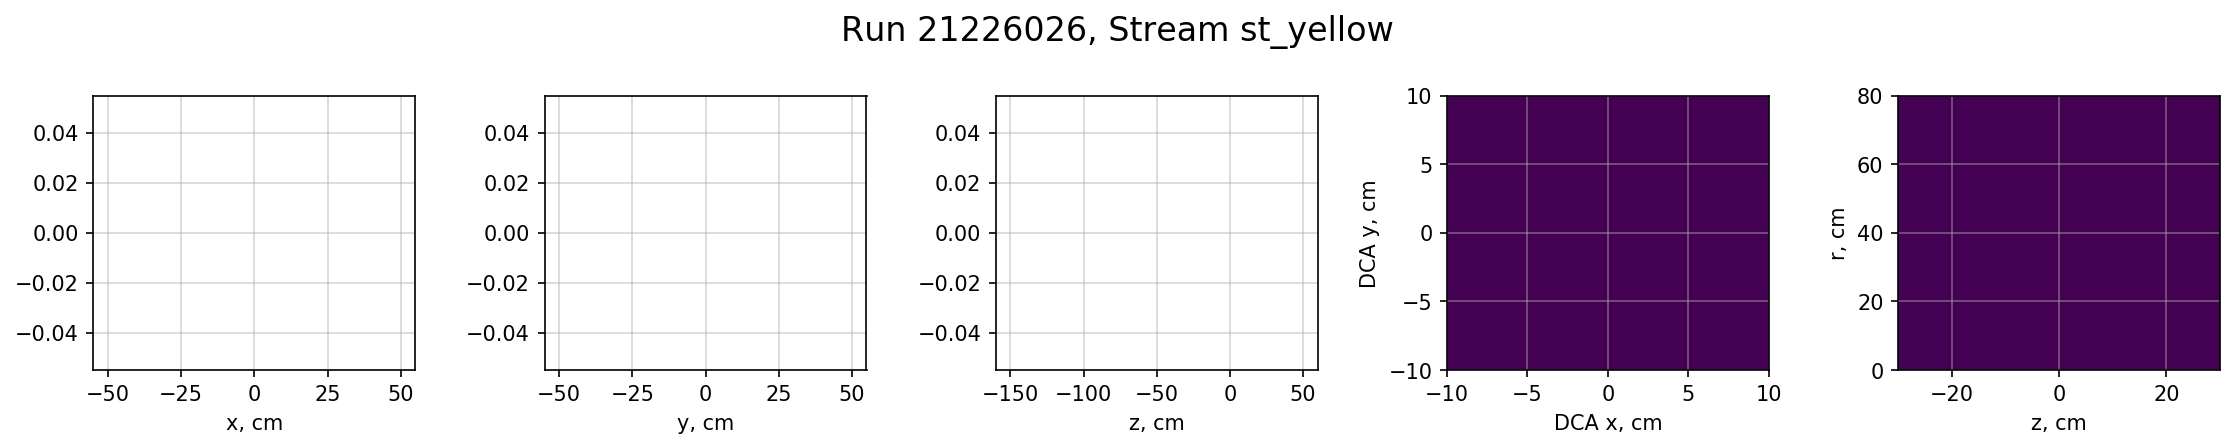

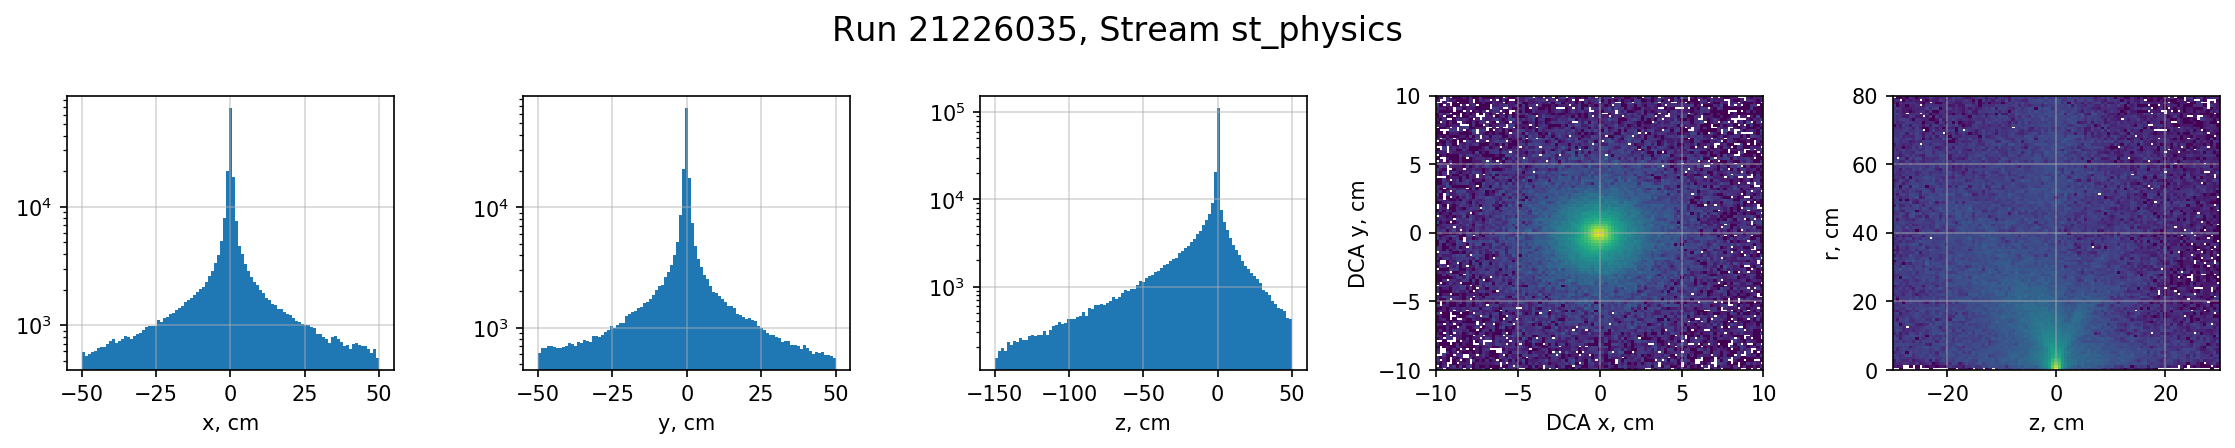

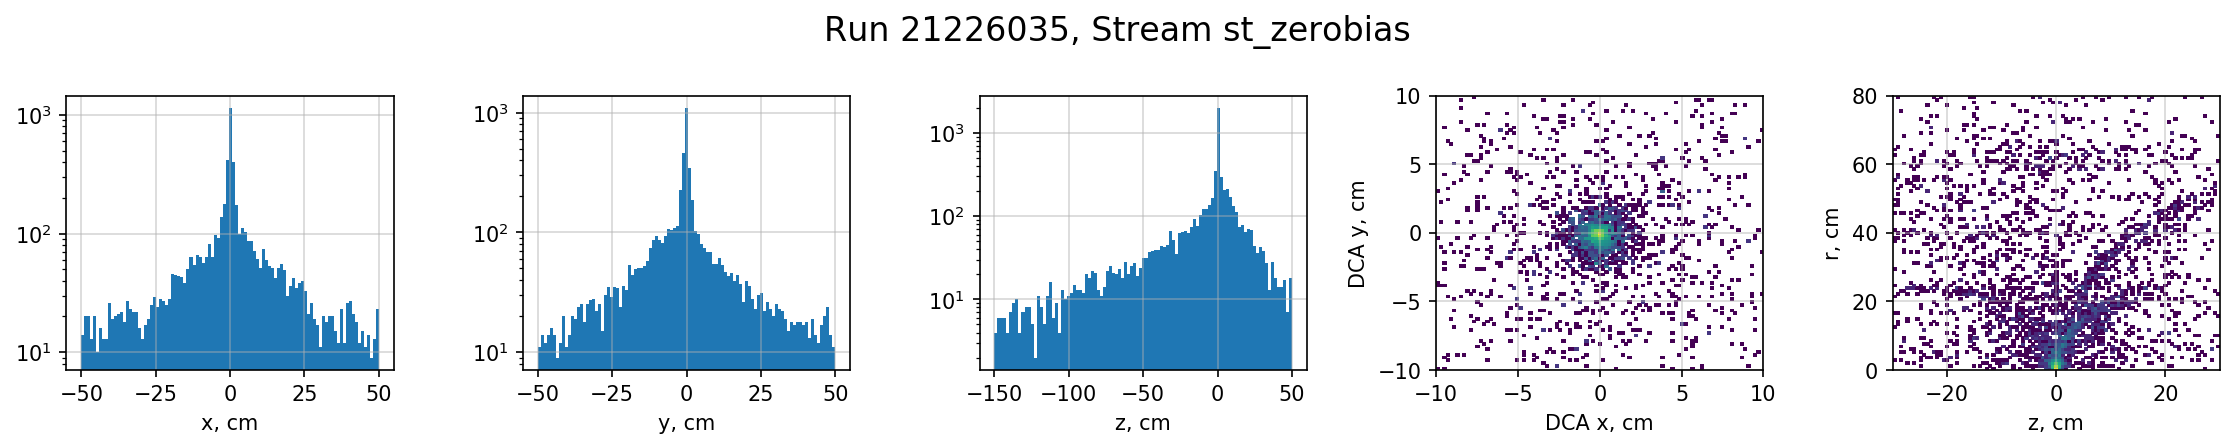

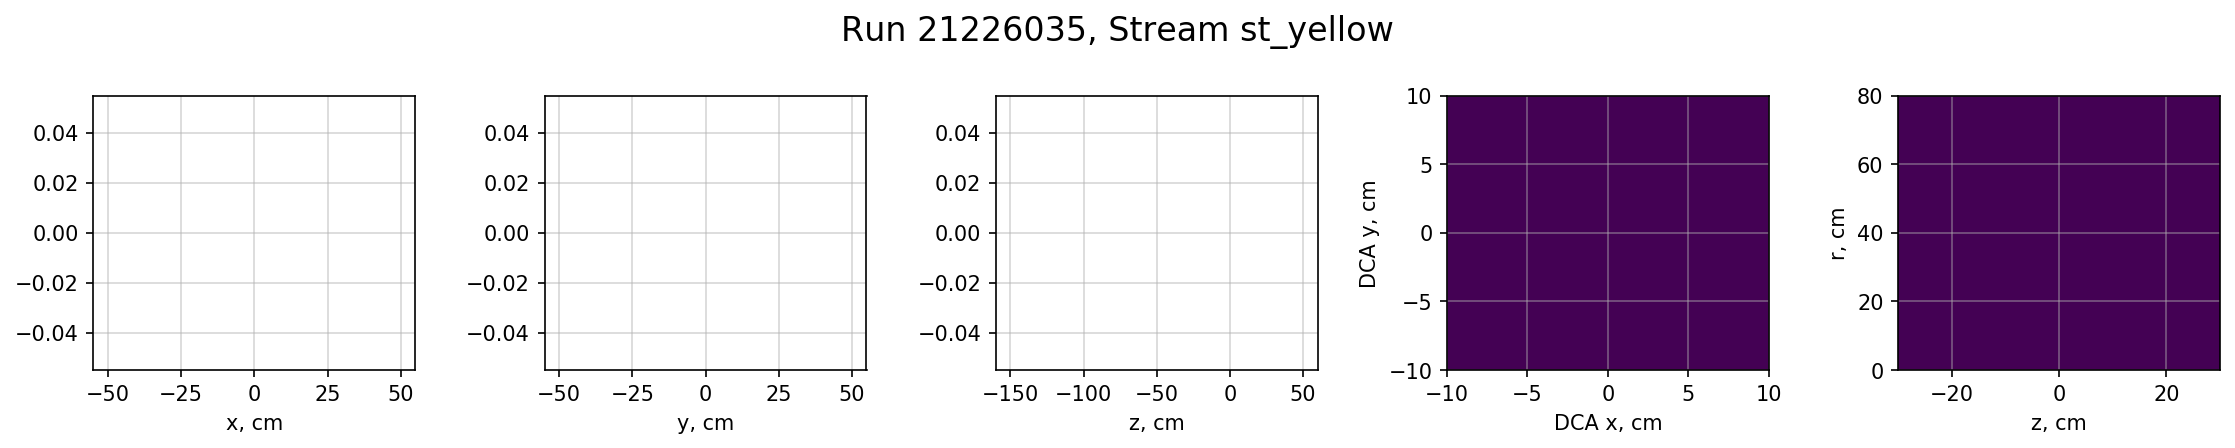

In [13]:
def plot_dca(df, tag):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
    indexer = pt_indexers[tag][1]
    
    a = ax[0]
    n, _, _ = a.hist(df.loc[indexer].dcax, bins=bins)
    a.set_yscale('log') if np.sum(n) else None
    a.set_xlabel('x, cm')
    a.grid()
    
    a = ax[1]
    n, _, _ = a.hist(df.loc[indexer].dcay, bins=bins)
    a.set_xlabel('y, cm')
    a.set_yscale('log') if np.sum(n) else None
    a.grid()
    
    a = ax[2]
    n, _, _ = a.hist(df.loc[indexer].dcaz, bins=np.linspace(-150,50,100))
    a.set_xlabel('z, cm')
    a.set_yscale('log') if np.sum(n) else None
    a.grid()
    
    a = ax[3]
    norm = mpl.colors.LogNorm() if np.sum(n) else None
    a.hist2d(df.loc[indexer].dcax, df.loc[indexer].dcay, bins=[np.linspace(-10,10,100), np.linspace(-10,10,100)], norm=norm)
    a.set_xlabel('DCA x, cm')
    a.set_ylabel('DCA y, cm')
    a.grid()
    
    a = ax[4]
    norm = mpl.colors.LogNorm() if np.sum(n) else None
    r = np.sqrt(df.loc[indexer].dcax**2 + df.loc[indexer].dcay**2)
    a.hist2d(df.loc[indexer].dcaz, r, bins=[np.linspace(-30,30,100), np.linspace(0,80,100)], norm=norm)
    a.set_xlabel('z, cm')
    a.set_ylabel('r, cm')
    a.grid()
    
    plt.suptitle(f'Run {tag.run_name}, Stream {tag.stream_name}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    plt.show()

bins = np.linspace(-50, 50, 100)

for tag in tags:
    df = dfs[tag]
    plot_dca(df, tag)

Now let's look at the number of events with at least one track with $P_T$ above the threshold in each of the streams

stream      :      P_T > 0    P_T > 0.2    P_T > 0.5
   r26     ph:          932          929          913
   r26     zb:          999          892          699
   r26     ye:         3080         2658         2349
   r35     ph:          909          898          884
   r35     zb:          421          389          303
   r35     ye:         3462         3066         2610


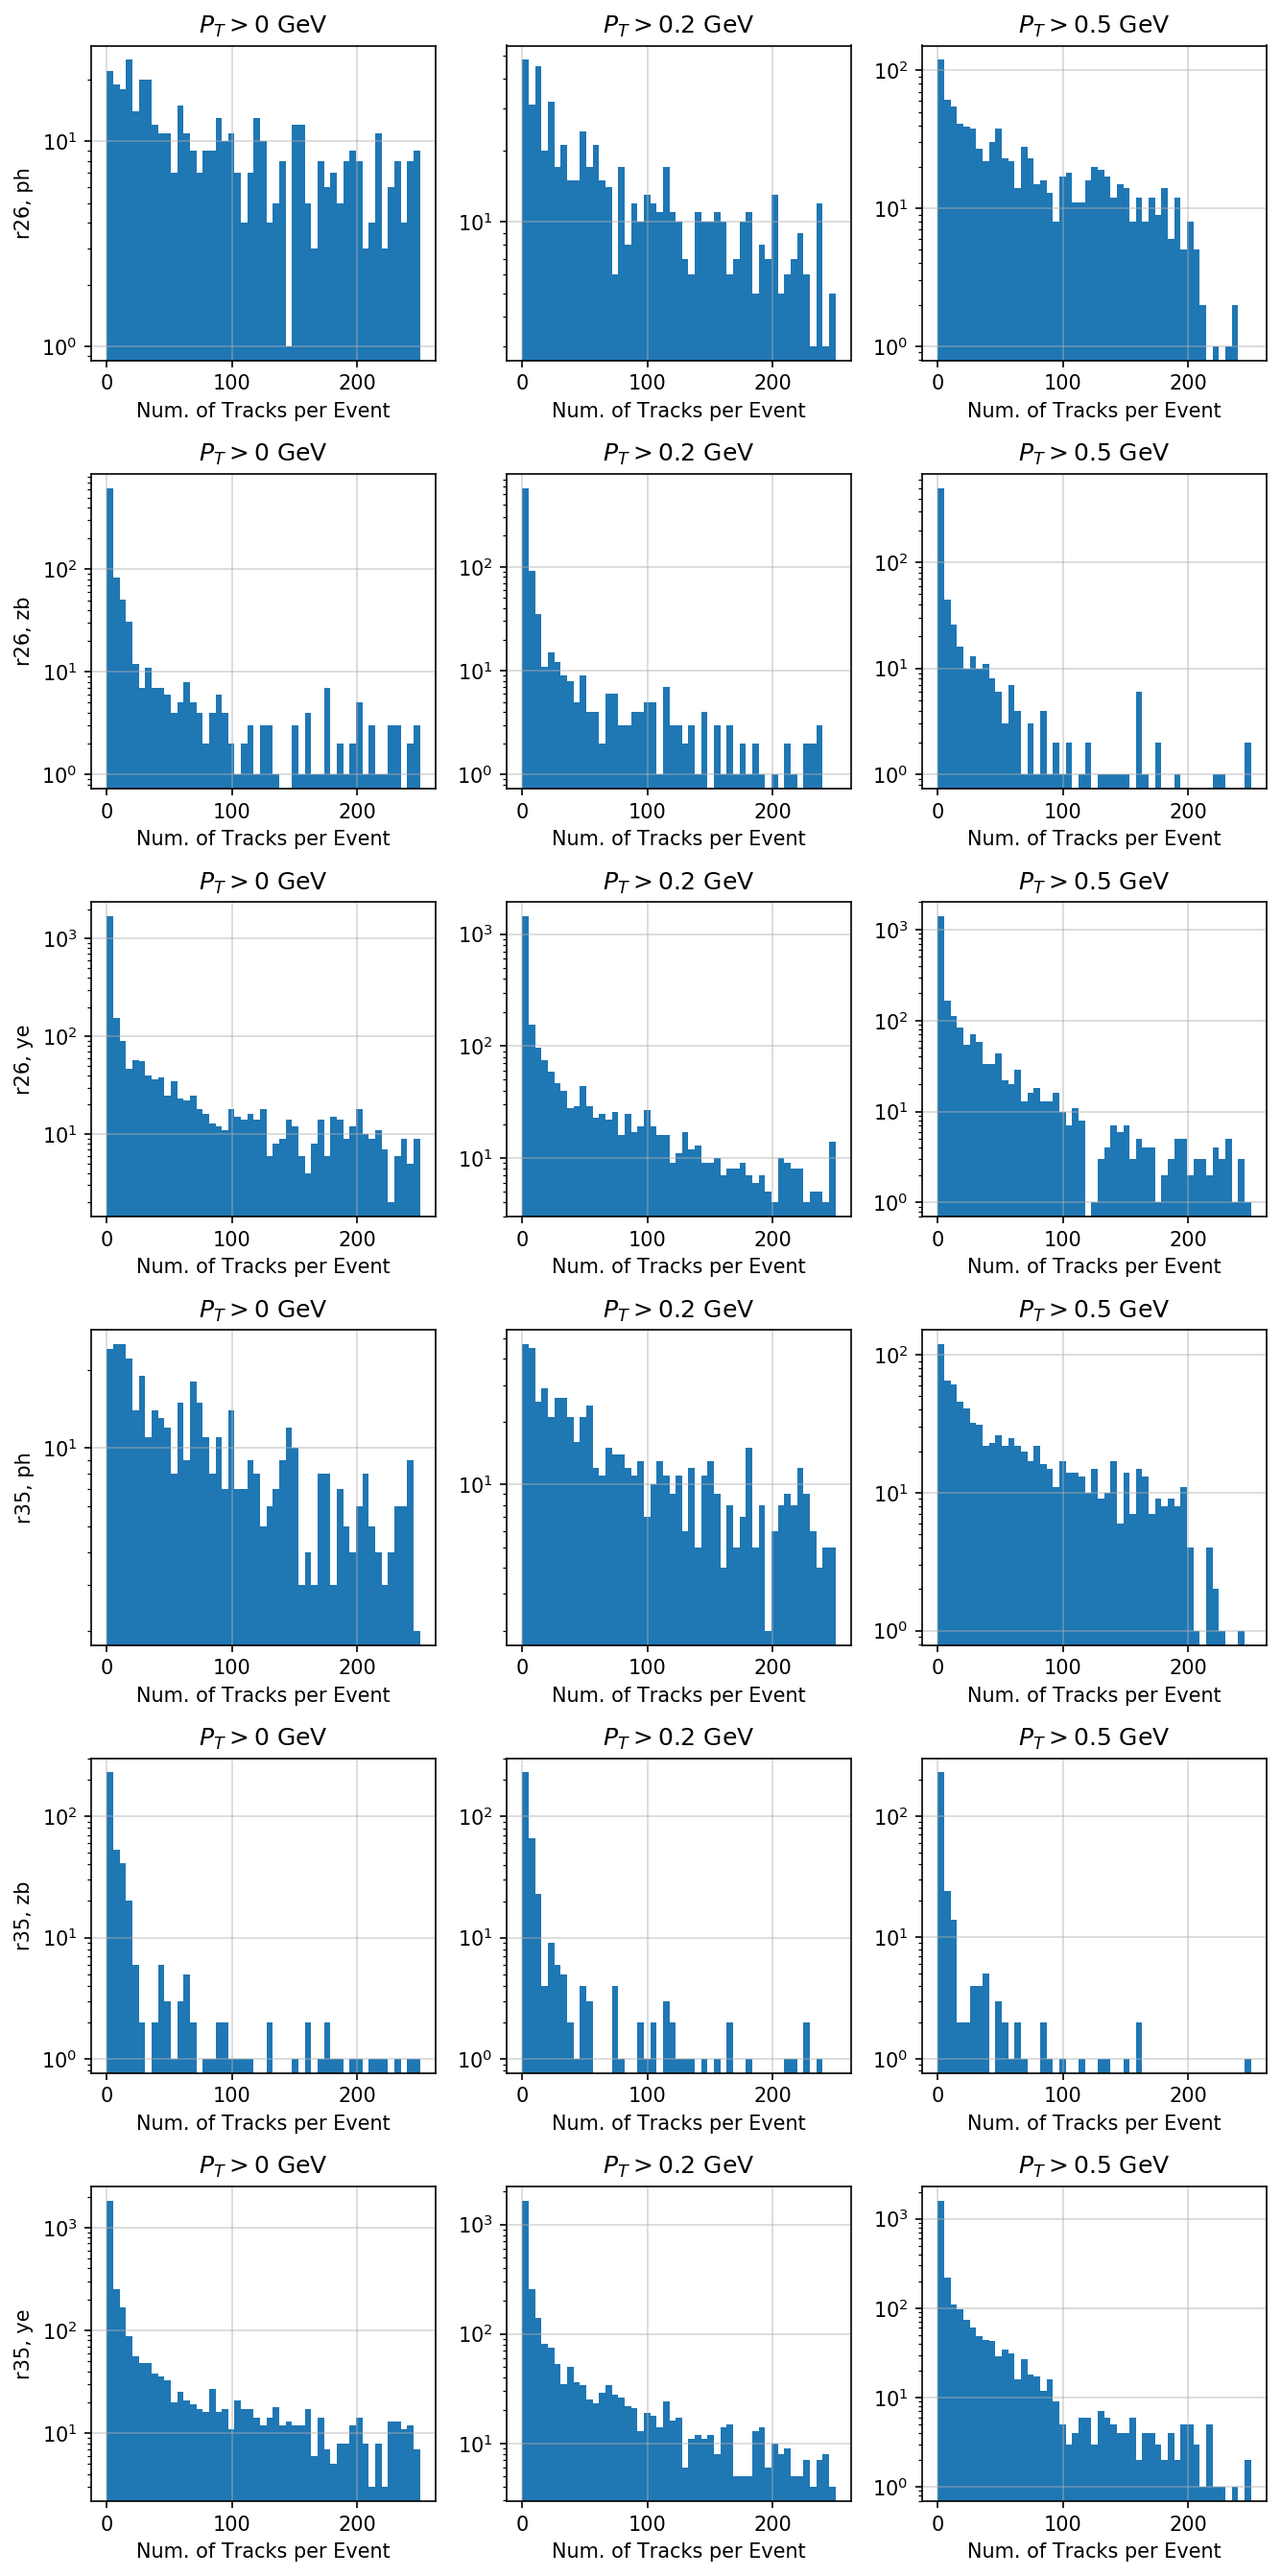

In [14]:
fig, ax = plt.subplots(len(dfs), 3, figsize=(9, 18))

bins = np.linspace(0, 250, 50)

print(f'{"stream": <12}: {"P_T > 0": >12} {"P_T > 0.2": >12} {"P_T > 0.5": >12}')

for i, (tag, df) in enumerate(dfs.items()):
    
    # P_T > 0
    indexer = pt_indexers[tag][1]
    n_tracks_per_event = df.loc[indexer].groupby(level=['file','entry']).size()
    n_events_with_trakcs_1 = np.count_nonzero(n_tracks_per_event)
    
    a = ax[i, 0]
    a.hist(n_tracks_per_event, bins=bins)
    a.set_title(f'$P_T > 0$ GeV')
    a.set_xlabel('Num. of Tracks per Event')
    a.set_ylabel(f'{tag.run}, {tag.stream}')
    a.set_yscale('log')
    a.grid()    
    
    # P_T > 0.2
    indexer = pt_indexers[tag][3]
    n_tracks_per_event = df.loc[indexer].groupby(level=['file','entry']).size()
    n_events_with_trakcs_3 = np.count_nonzero(n_tracks_per_event)
    
    a = ax[i, 1]
    a.hist(n_tracks_per_event, bins=bins)
    a.set_title(f'$P_T > 0.2$ GeV')
    a.set_xlabel('Num. of Tracks per Event')
    a.set_yscale('log')
    a.grid()    
    
    # P_T > 0.5
    indexer = pt_indexers[tag][6]
    n_tracks_per_event = df.loc[indexer].groupby(level=['file','entry']).size()
    n_events_with_trakcs_6 = np.count_nonzero(n_tracks_per_event)
    
    a = ax[i, 2]
    a.hist(n_tracks_per_event, bins=bins)
    a.set_title(f'$P_T > 0.5$ GeV')
    a.set_xlabel('Num. of Tracks per Event')
    a.set_yscale('log')
    a.grid()    
    
    print(f'{tag.run: >6} {tag.stream: >6}: {n_events_with_trakcs_1: >12} {n_events_with_trakcs_3: >12} {n_events_with_trakcs_6: >12}')

plt.tight_layout()
plt.show()

### Projected track Z and DCA near beam

Tracks can be extrapolated to near the nominal beam position of (x,y) = (0,0).
We use the tracks' innermost and outermost positions to extrapolate in the r-z plane and
the tracks momentum to project to (0,0) in the x-y plane

In [15]:
c_light = 2.99792458e+10
#B_factor = 1e-3 * 1e-14 * c_light
B_scale = 1e-3 * 1e-4 * 2.99792458

Vec2 = collections.namedtuple('Vec2', ['x', 'y'])

def assign(df):
    df = df.assign( Bs = df.B * B_scale )
    k = np.sqrt( (df.ohy - df.hy)**2 + (df.ohx - df.hx)**2 ) / (df.ohz - df.hz)
    df = df.assign(
        pvz  = df.hz - np.sqrt(df.hx**2 + df.hy**2) / k,
        dca2 = track.dca2D( Vec2(0, 0), df.hx, df.hy, df.hpx, df.hpy, df.hpz, df.q, df.Bs)
    )
    return df

dfs_ = { tag: assign(df) for tag, df in dfs.items()}

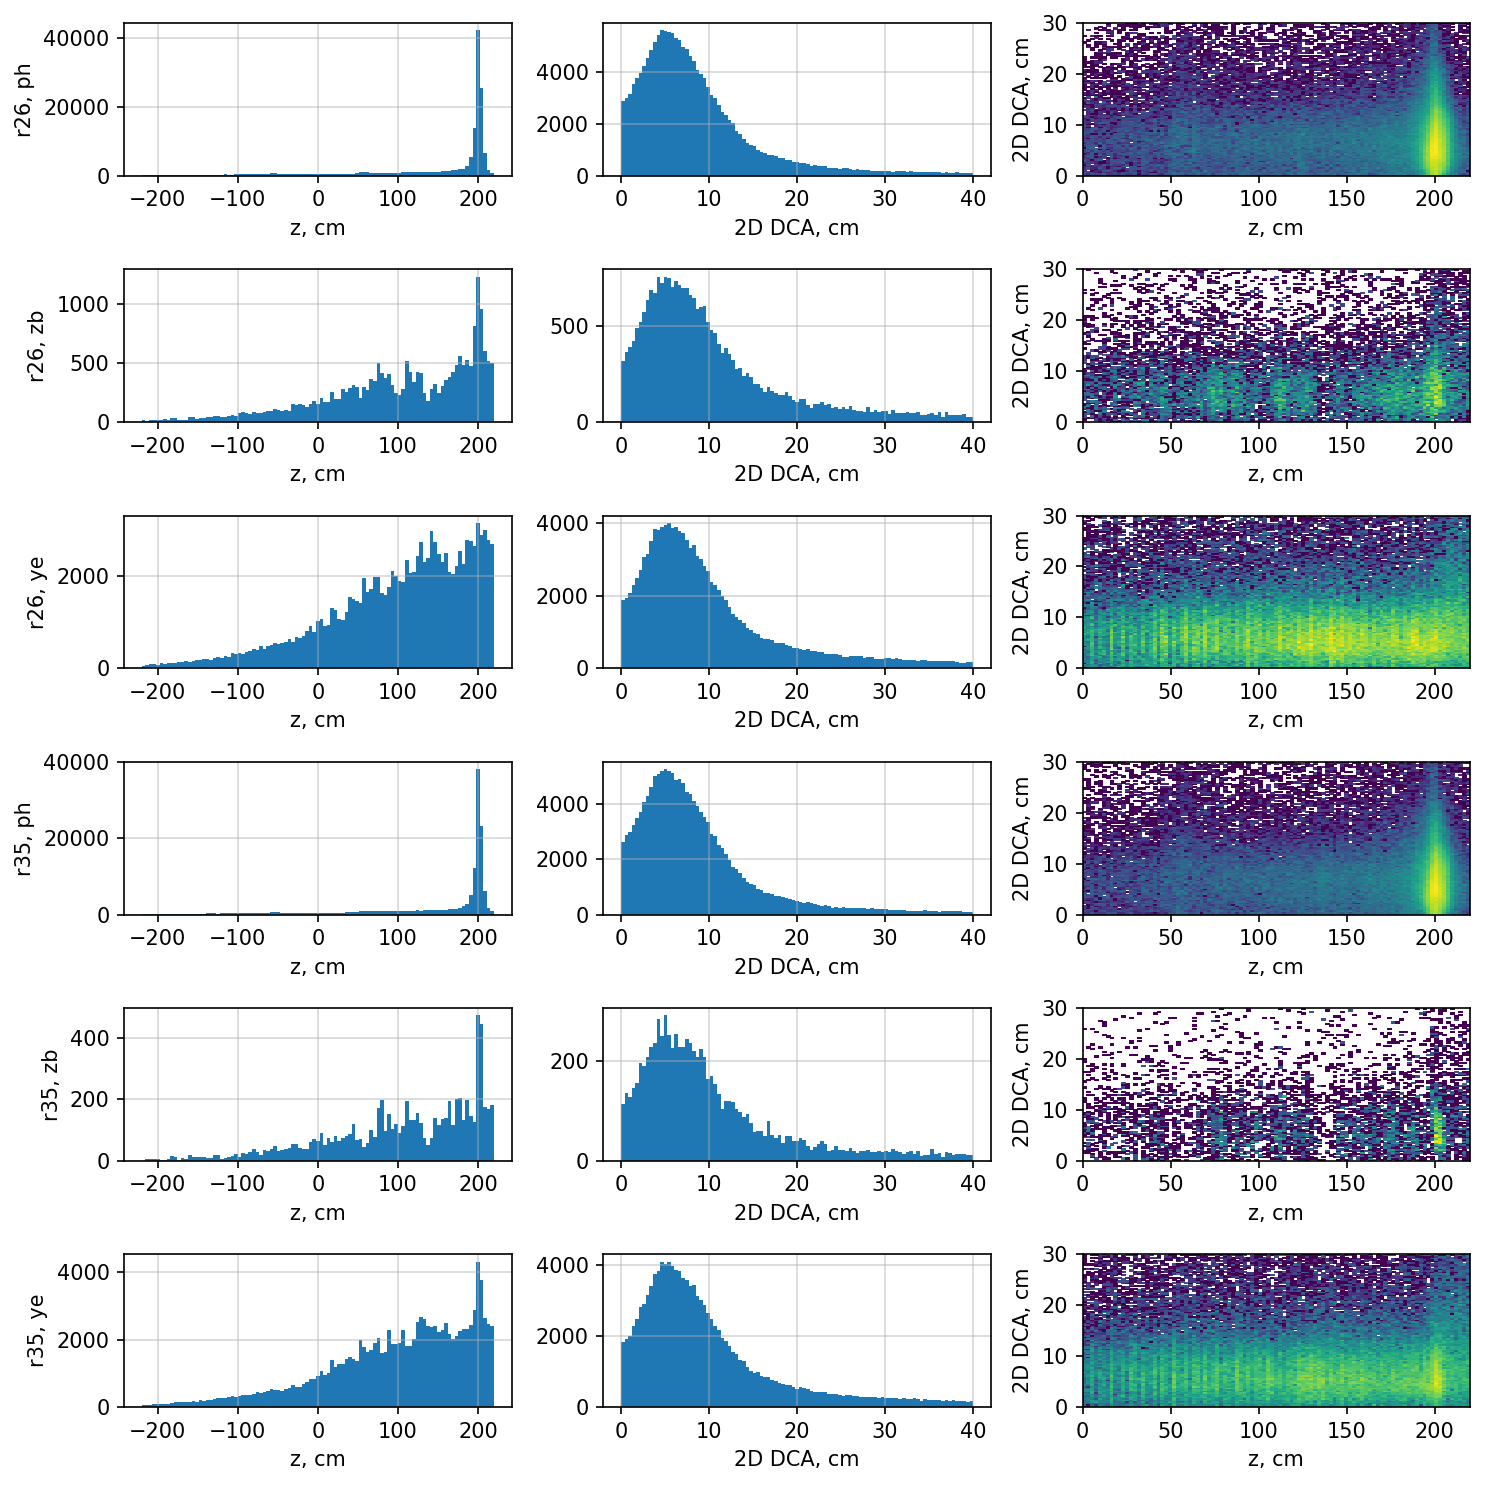

In [16]:
fig, ax = plt.subplots(len(dfs_), 3, figsize=(10, 10))

bins_pvz = np.linspace(-220, 220, 100)
bins_dca = np.linspace(0, 40, 100)

for i, (tag, df) in enumerate(dfs_.items()):
    indexer = pt_indexers[tag][3]
    
    a = ax[i,0]
    a.hist(df.loc[indexer].pvz,   bins=bins_pvz)
    a.set_xlabel('z, cm')
    a.set_ylabel(f'{tag.run}, {tag.stream}')
    a.grid()    
    
    a = ax[i,1]
    a.hist(df.loc[indexer].dca2, bins=bins_dca)
    a.set_xlabel('2D DCA, cm')
    a.grid()    
    
    a = ax[i,2]
    a.hist2d(df.loc[indexer].pvz, df.loc[indexer].dca2, bins=[np.linspace(0,220,100), np.linspace(0,30,100)], norm=mpl.colors.LogNorm())
    a.set_xlabel('z, cm')
    a.set_ylabel('2D DCA, cm')
    a.set_ylim([0, 30])
    a.set_xlim([0, 220])

plt.tight_layout()
plt.show()

Next, I wanted to compare projected and reconstructed DCA parameters but the DCA values in MuDst are relative to a point/vertex. So, the comparison does not make sense.

<!--
fig, ax = plt.subplots(len(dfs_), 2, figsize=(6, 9))

bins_pvz = np.linspace(-250, 300, 100)
bins_dca = np.linspace(0, 40, 100)

for i, (tag, df) in enumerate(dfs_.items()):
    indexer = pt_indexers[tag][3]
    
    a = ax[i,0]
    a.hist2d(df.loc[indexer].dcaz, df.loc[indexer].pvz, bins=[bins_pvz, bins_pvz], norm=mpl.colors.LogNorm())
    a.set_title(f'{streams[tag]}')
    a.set_xlabel('z, cm')
    a.grid()    
    
    a = ax[i,1]
    dca2d = np.sqrt(df.loc[indexer].dcax**2 + df.loc[indexer].dcay**2)
    a.hist2d(dca2d, df.loc[indexer].dca2, bins=[np.linspace(0,30,100), np.linspace(0,30,100)], norm=mpl.colors.LogNorm())

plt.tight_layout()
plt.show()
-->

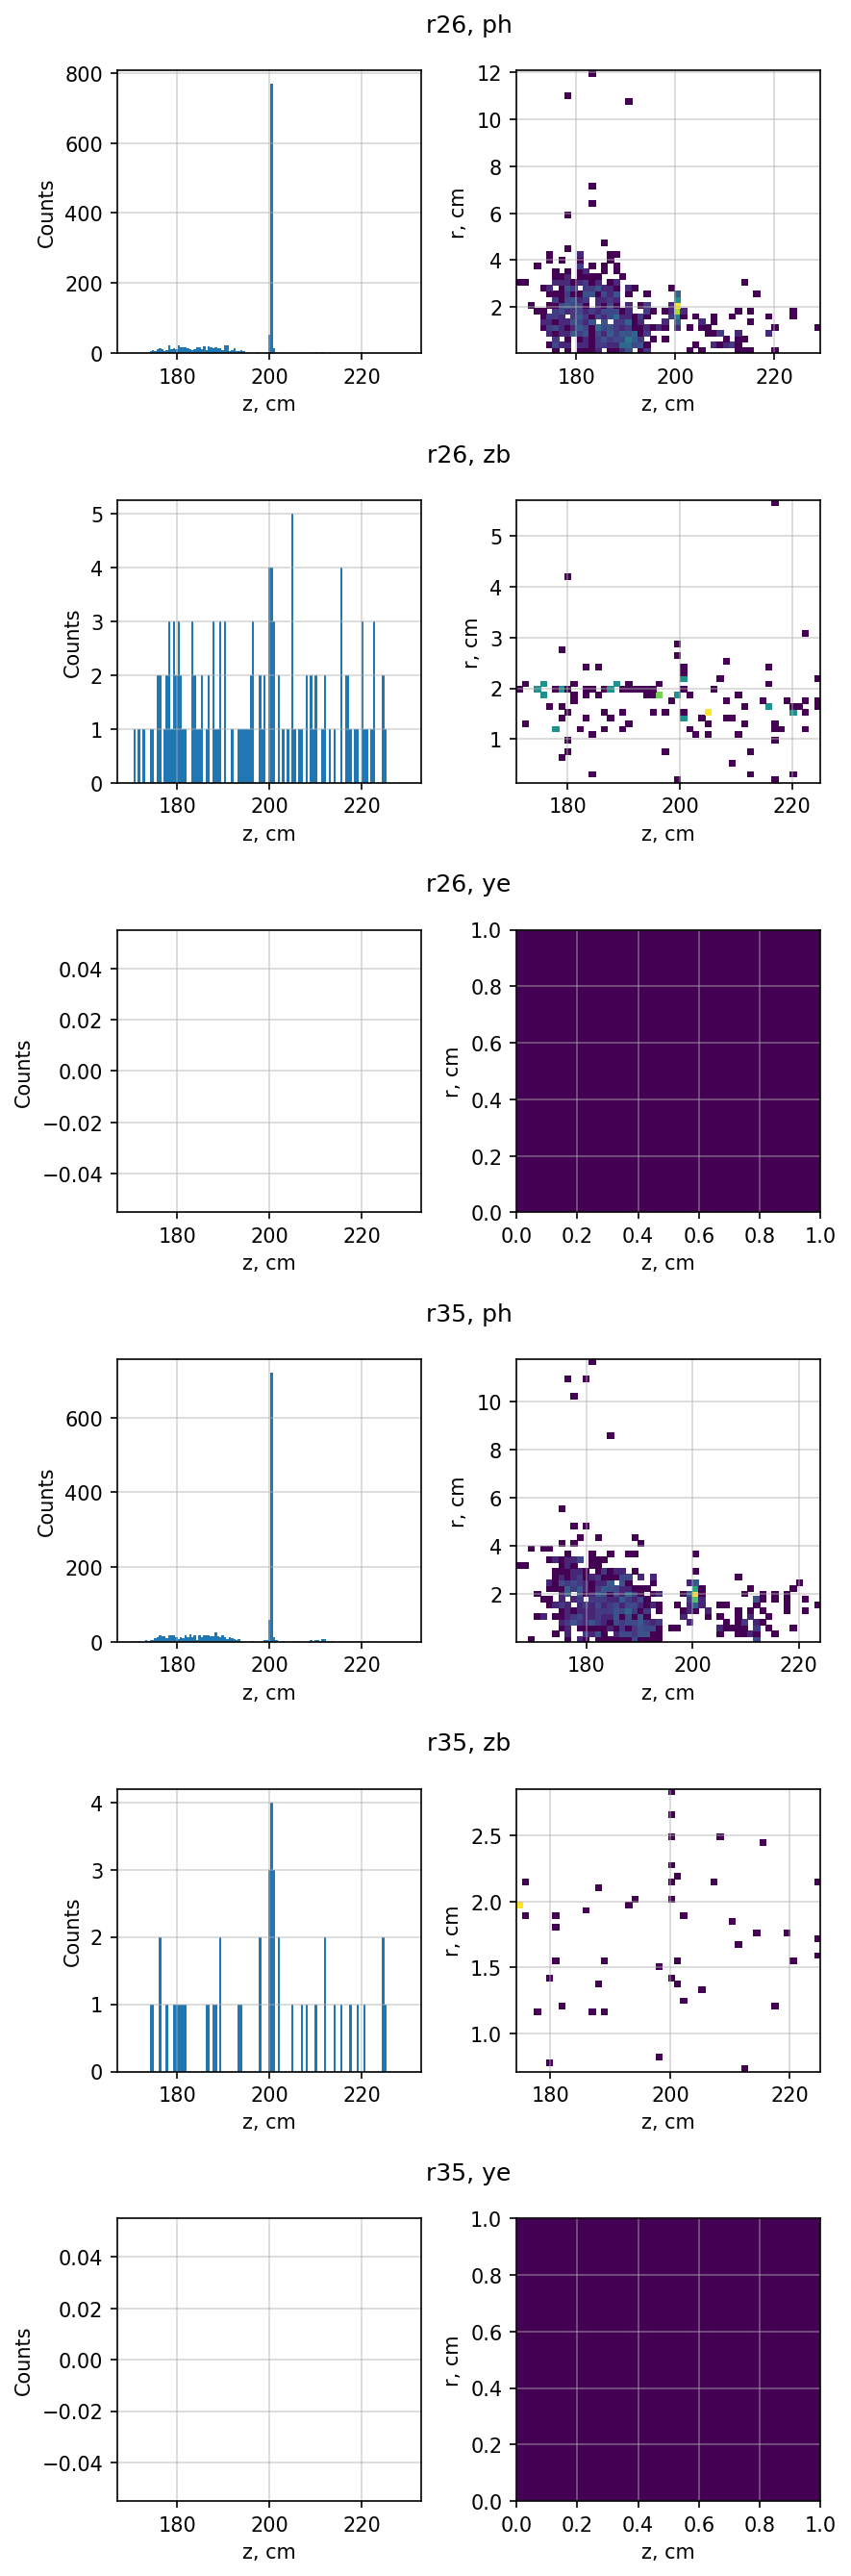

In [17]:
fig, ax_rows = plt.subplots(nrows=len(dfvs), ncols=1, figsize=(6, 18))

for ax_row, tag in zip(ax_rows, dfvs.keys()):
    ax_row.set_title(f'{tag.run}, {tag.stream}\n')
    ax_row.axis('off')
    
for i, (tag, df) in enumerate(dfvs.items()):
    
    ax = fig.add_subplot(len(dfvs), 2, 2*i+1)
    ax.hist(df.vz, bins=np.linspace(170, 230, 120))
    ax.set_xlabel('z, cm')
    ax.set_ylabel('Counts')
    ax.grid()
    
    vr = np.sqrt(df.vx**2 + df.vy**2)
    norm = mpl.colors.LogNorm() if len(vr) else None
    
    ax = fig.add_subplot(len(dfvs), 2, 2*i+2)
    ax.hist2d(df.vz, vr, bins=[50, 50], norm=norm)
    ax.set_xlabel('z, cm')
    ax.set_ylabel('r, cm')
    ax.grid()

plt.tight_layout()
plt.show()

The coordinates of the inner and outer most hits on the track

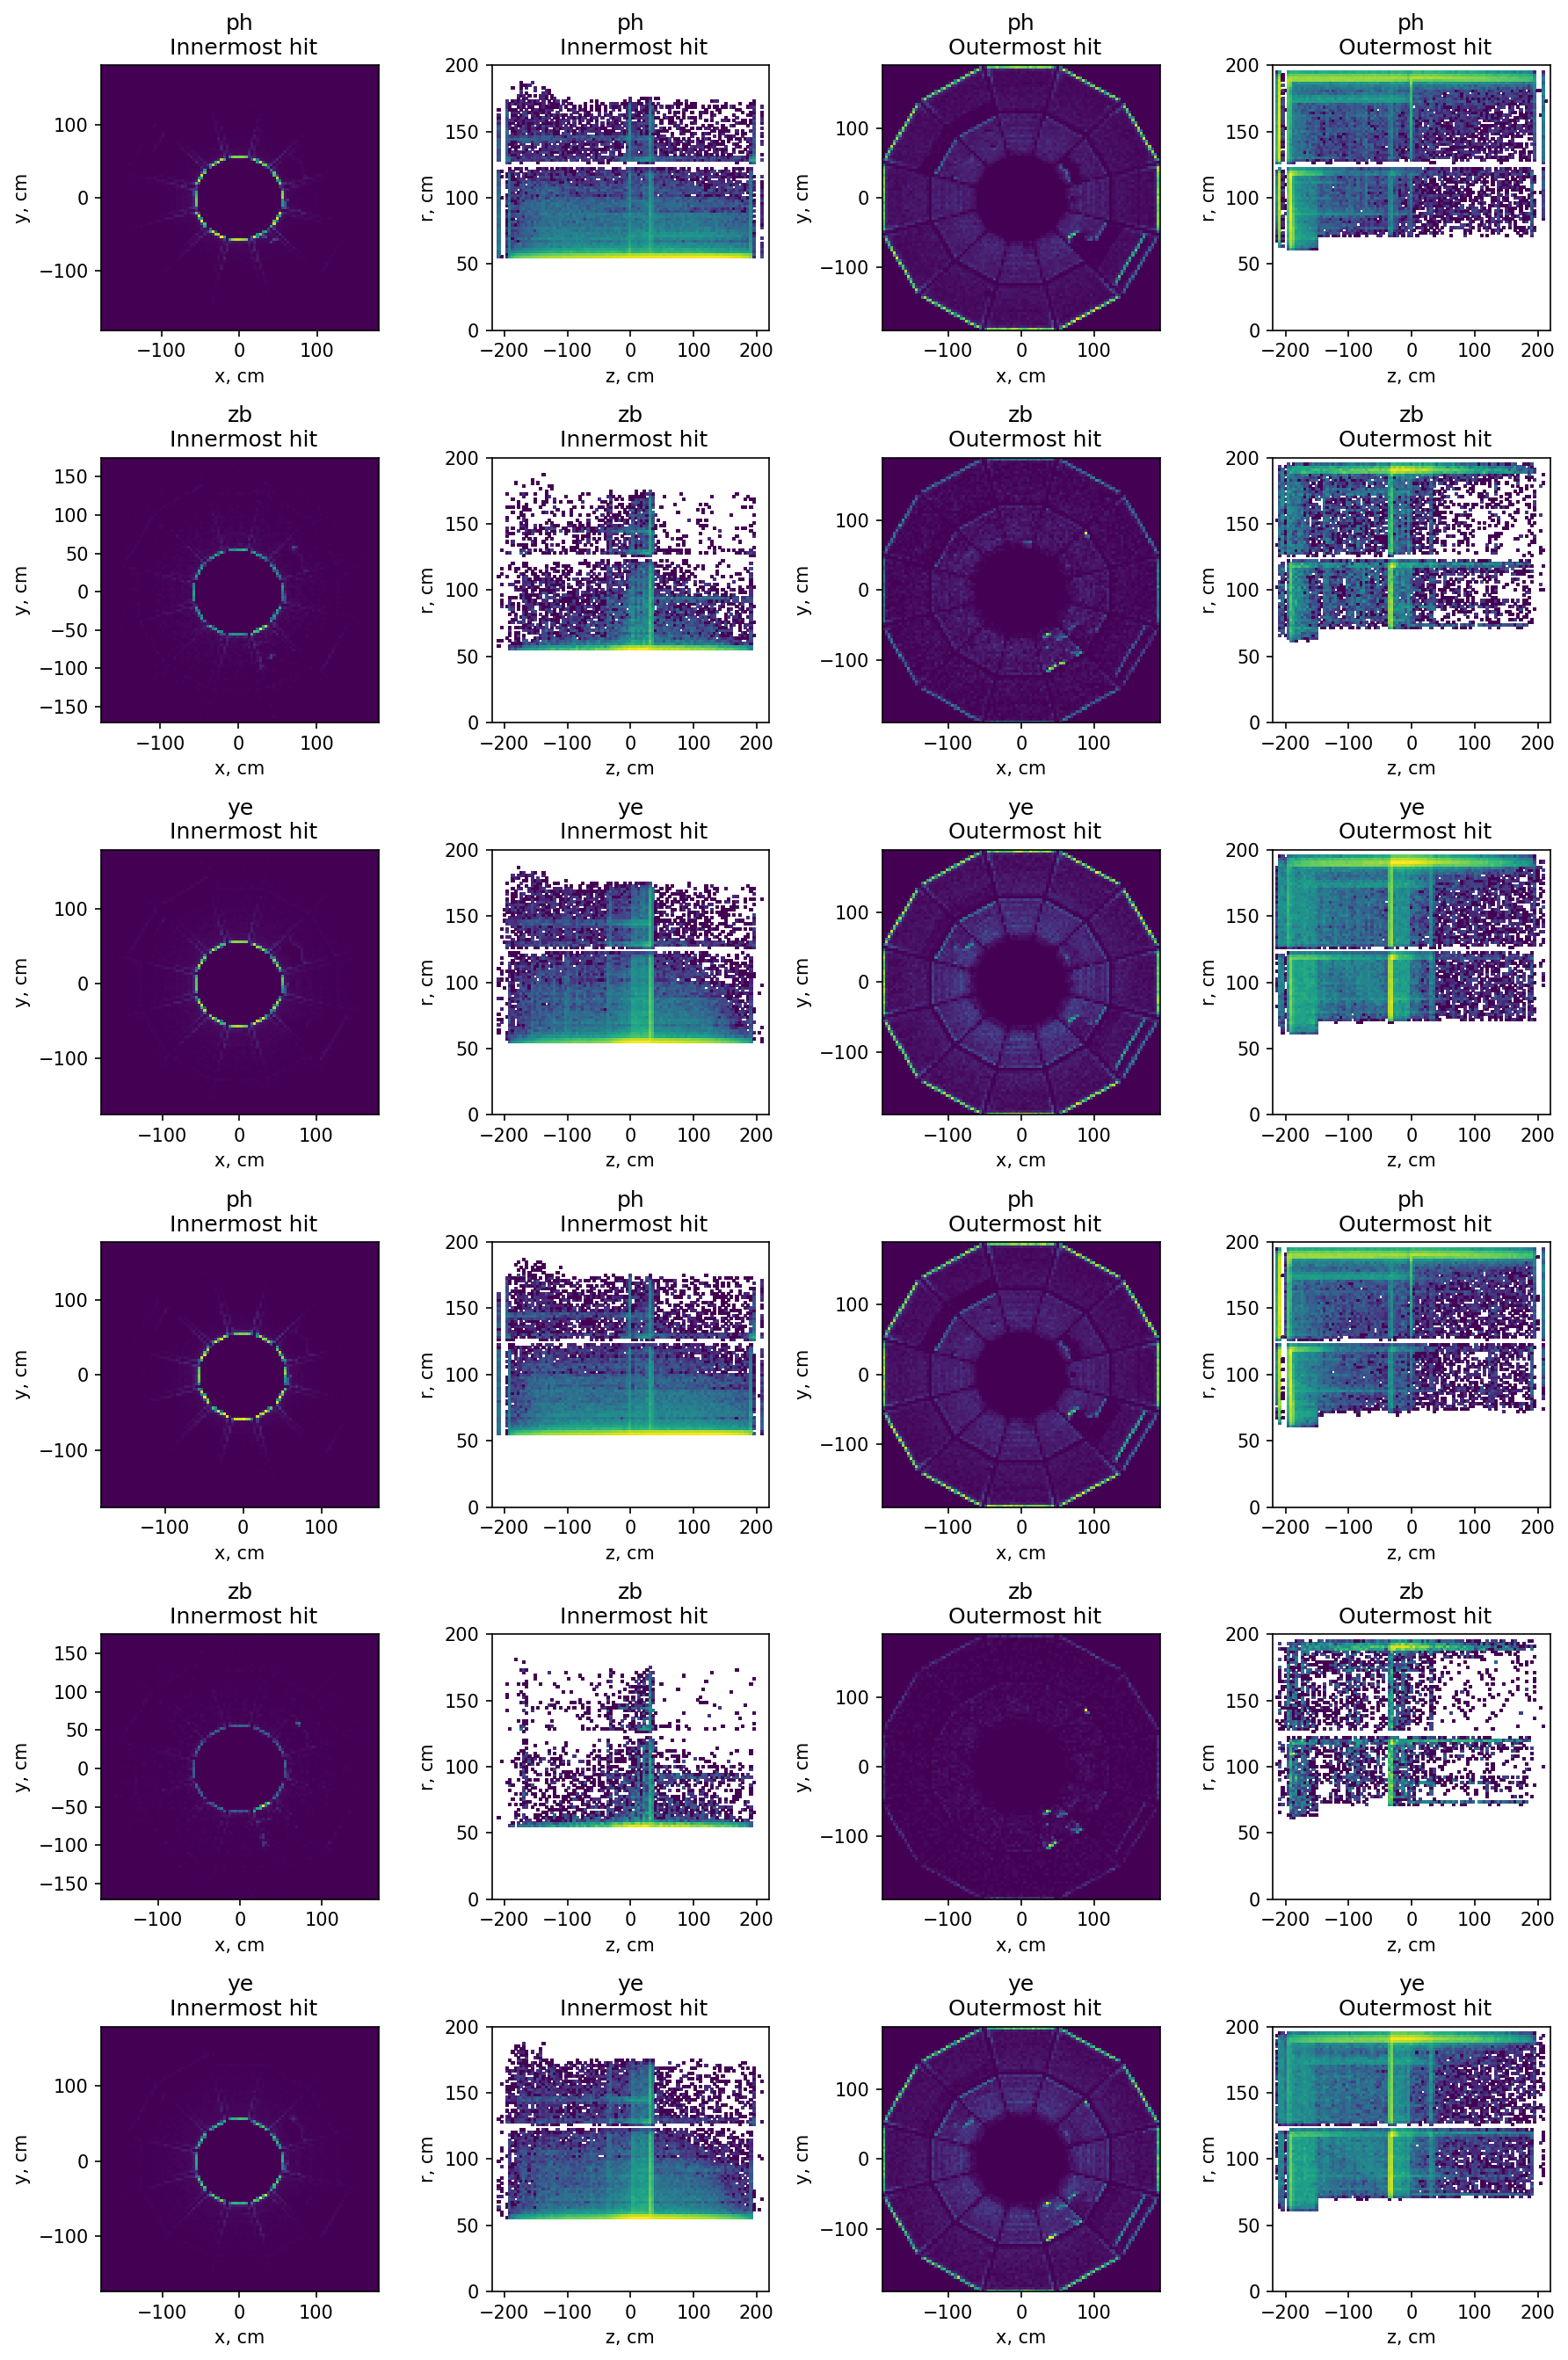

In [18]:
fig, ax = plt.subplots(len(dfs_), 4, figsize=(12, 18))

for i, (tag, df) in enumerate(dfs_.items()):
    indexer = pt_indexers[tag][3]
    
    a = ax[i,0]
    a.hist2d(df.loc[indexer].hx, df.loc[indexer].hy, bins=[100,100])   #norm=mpl.colors.LogNorm())
    a.set_title(f'{tag.stream}\n Innermost hit')
    a.set_xlabel('x, cm')
    a.set_ylabel('y, cm')
    
    a = ax[i,1]
    r = np.sqrt(df.loc[indexer].hx**2 + df.loc[indexer].hy**2)
    a.hist2d(df.loc[indexer].hz, r, bins=[np.linspace(-220,220,100), np.linspace(0,200,100)], norm=mpl.colors.LogNorm())
    a.set_title(f'{tag.stream}\n Innermost hit')
    a.set_xlabel('z, cm')
    a.set_ylabel('r, cm')
    
    a = ax[i,2]
    a.hist2d(df.loc[indexer].ohx, df.loc[indexer].ohy, bins=[100,100]) #norm=mpl.colors.LogNorm())
    a.set_title(f'{tag.stream}\n Outermost hit')
    a.set_xlabel('x, cm')
    a.set_ylabel('y, cm')
    
    a = ax[i,3]
    r = np.sqrt(df.loc[indexer].ohx**2 + df.loc[indexer].ohy**2)
    a.hist2d(df.loc[indexer].ohz, r, bins=[np.linspace(-220,220,100), np.linspace(0,200,100)], norm=mpl.colors.LogNorm())
    a.set_title(f'{tag.stream}\n Outermost hit')
    a.set_xlabel('z, cm')
    a.set_ylabel('r, cm')

plt.tight_layout()
plt.show()

### Rejection of tracks in vertex finder

In [19]:
%%time

rootfiles_vf = {}
rootfiles_vf['zb'] = f'{prefix}/tracks_vfit_st_zerobias_21226035.root'
rootfiles_vf['ye'] = f'{prefix}/tracks_vfit_st_yellow_21226035.root'
    
branches_vf = {
    'flag'         : 'b.flag',
    'n_fit_points' : 'b.n_fit_points',
    'ftpc'         : 'b.ftpc',
    'helix_valid'  : 'b.helix_valid',
    'length'       : 'b.length',
    'impact'       : 'b.impact',
}

def make_df_vf(rootfile): 
    df, _ = stu.make_df(rootfile, 't', 'b', {})
    return df

def rename_columns(df):
    df.columns = branches_vf.keys()
    return df
    
dfs_vf = { tag: make_df_vf(rootfile) for tag, rootfile in rootfiles_vf.items()}
dfs_vf = { tag: rename_columns(df) for tag, df in dfs_vf.items()}

#dfs_vf['zb']
df_zb, df_ye = dfs_vf.values()

CPU times: user 70.6 ms, sys: 4.59 ms, total: 75.2 ms
Wall time: 124 ms


In [20]:
#for tag, df in dfs_vf.items():
#    df.info()

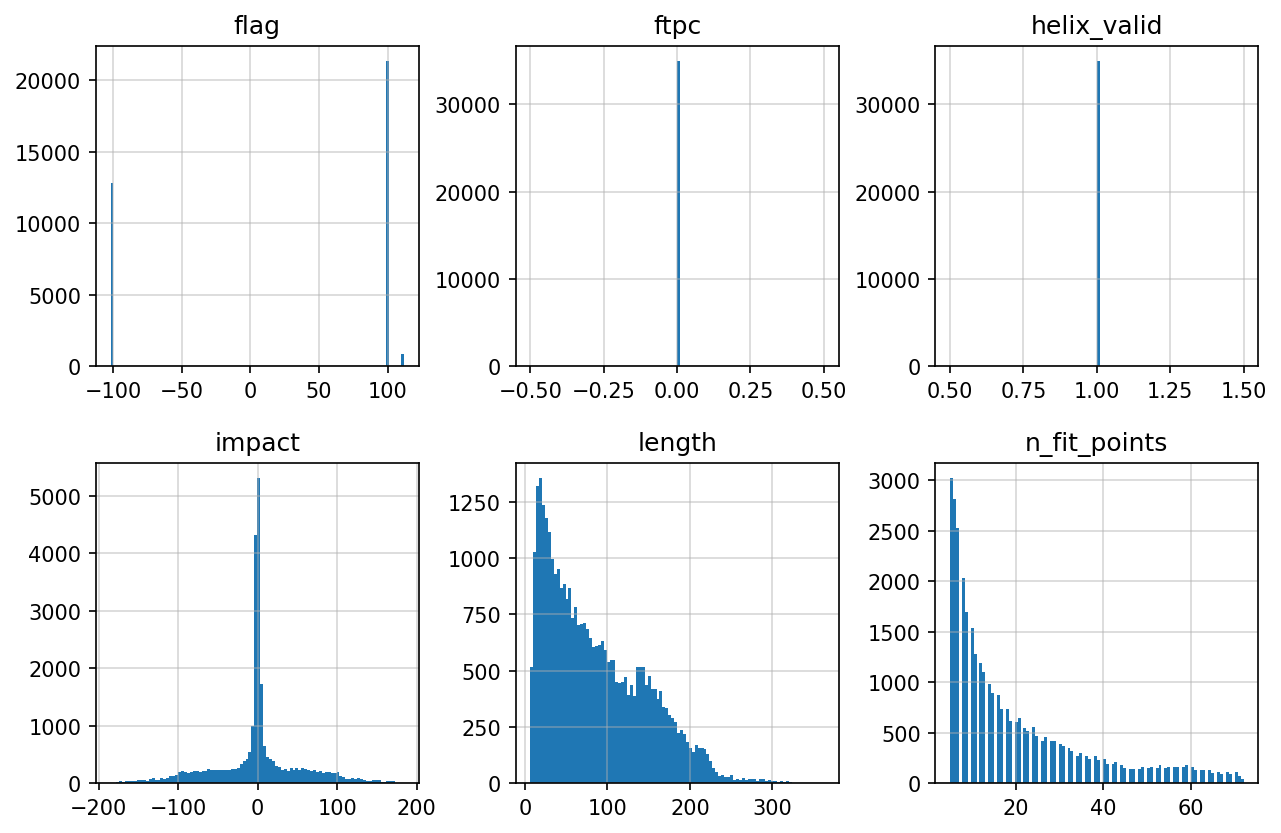

In [21]:
df_ye.hist(layout=(3,3), figsize=(10,10), bins=100)
#df_zb.hist(layout=(3,3), figsize=(10,10), bins=100)
plt.show()

In [22]:
select_vf = lambda df:  (df.flag >= 0) & (df.impact <= 3) & (df.n_fit_points >= 20)

In [23]:
#df_ye.loc[select_vf(df_ye)]

In [24]:
#np.count_nonzero(select_vf_tracks(df))
#select_vf_tracks(df_ye)

In [25]:
for tag, df in dfs_vf.items():
    n_good_tracks = np.count_nonzero(select_vf(df))
    frac = n_good_tracks/len(df) * 100
    print(f'{tag}: {n_good_tracks} of {len(df)} {frac:5.1f}%')

zb: 7039 of 32165  21.9%
ye: 8894 of 34991  25.4%


### Plots for wider [175, 225] vertex z window 

Files now reconstructed with the wider window used for vertex search.
This was intended before but a pilot error leading to wrong conclusions about the vertex finding algorithm

We compare the data from same run ...035 before and after the fix

As expected, the plots for DCA now clearly show data in `st_yellow` stream similar to the `st_zerobias` one

In [26]:
runs = {'r35w': '21226035_wideVz'}
tags = get_tags(runs, streams)
rootfiles = get_mudst_files(tags) 
#pprint.pprint(rootfiles)

In [27]:
%%time
dfs = { tag: make_df(rootfiles_, branches_trk) for tag,rootfiles_ in rootfiles.items()}

CPU times: user 12.6 s, sys: 332 ms, total: 13 s
Wall time: 13.6 s


In [28]:
dfs = { tag: stu.add_track_params(df) for tag, df in dfs.items()}

In [29]:
pt_indexers = get_pt_indexers(dfs)

Run 21226035_wideVz st_physics  nan   294840   100.00%
Run 21226035_wideVz st_physics  0.0   293296    99.48%
Run 21226035_wideVz st_physics  0.1   218226    74.02%
Run 21226035_wideVz st_physics  0.2   155008    52.57%
Run 21226035_wideVz st_physics  0.3   112975    38.32%
Run 21226035_wideVz st_physics  0.4    81551    27.66%
Run 21226035_wideVz st_physics  0.5    58635    19.89%
Run 21226035_wideVz st_physics  1.0    13260     4.50%

Run 21226035_wideVz st_zerobias  nan    18894   100.00%
Run 21226035_wideVz st_zerobias  0.0    16652    88.13%
Run 21226035_wideVz st_zerobias  0.1    12415    65.71%
Run 21226035_wideVz st_zerobias  0.2     8957    47.41%
Run 21226035_wideVz st_zerobias  0.3     6522    34.52%
Run 21226035_wideVz st_zerobias  0.4     4622    24.46%
Run 21226035_wideVz st_zerobias  0.5     3316    17.55%
Run 21226035_wideVz st_zerobias  1.0      726     3.84%

Run 21226035_wideVz st_yellow  nan   316523   100.00%
Run 21226035_wideVz st_yellow  0.0   270900    85.59%
Ru

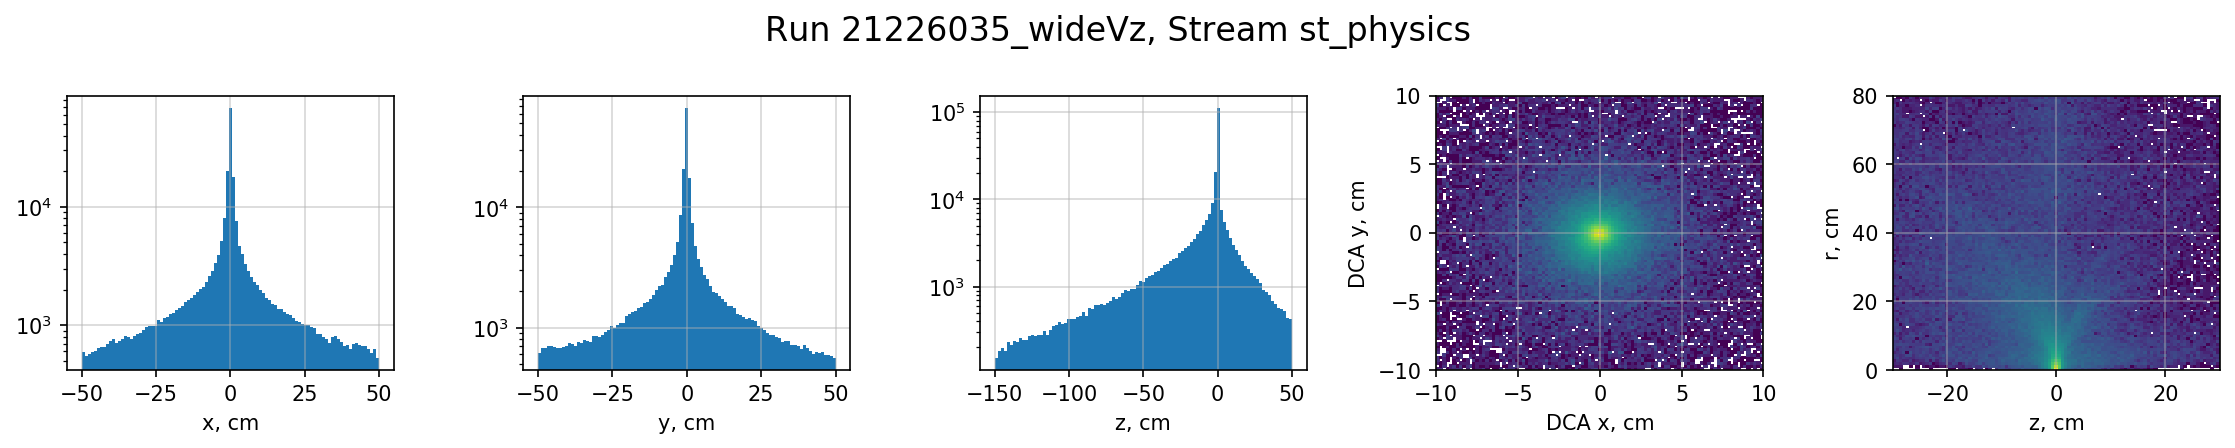

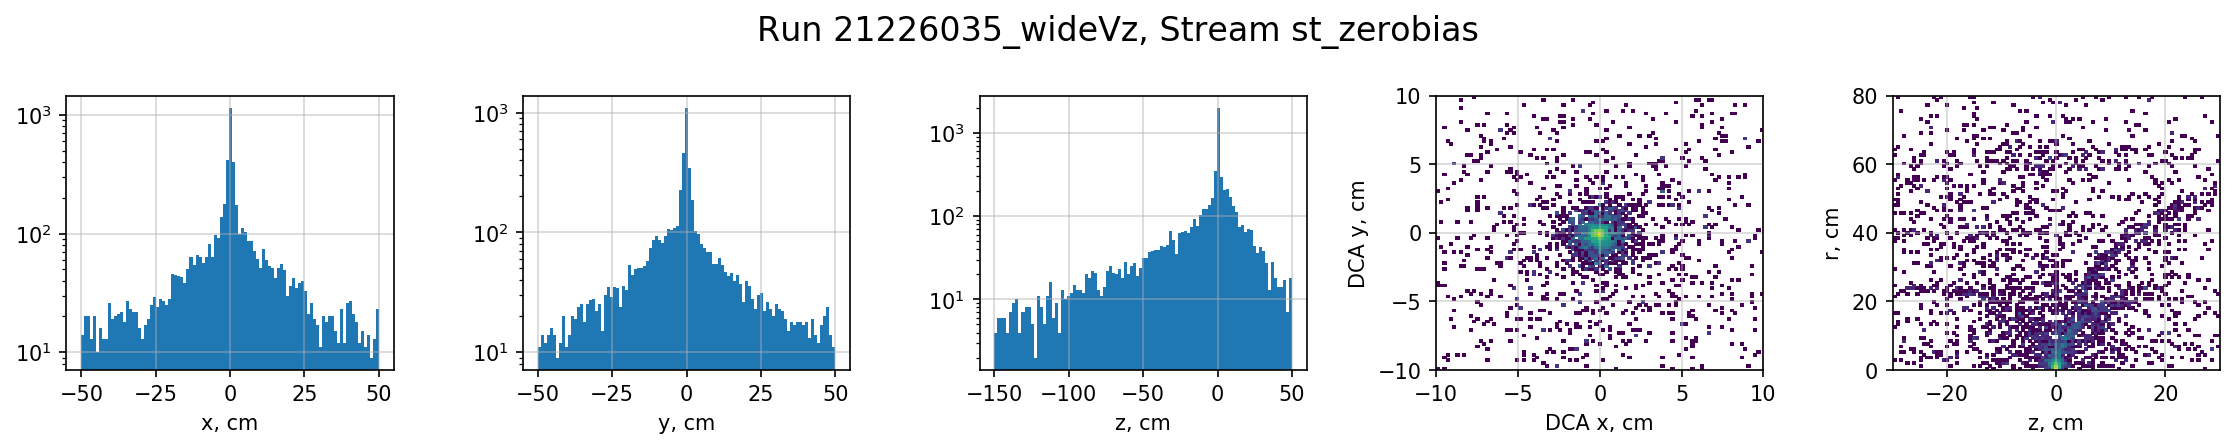

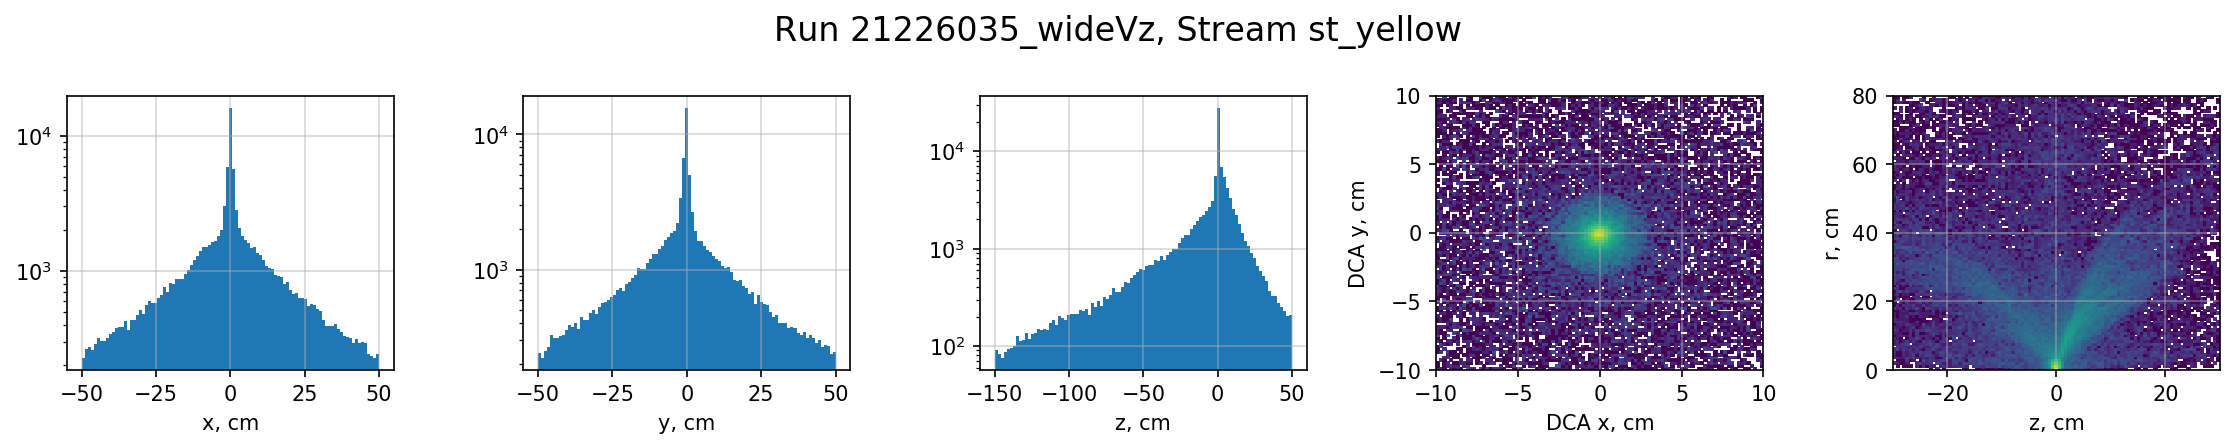

In [30]:
bins = np.linspace(-50, 50, 100)

for tag in tags:
    df = dfs[tag]
    plot_dca(df, tag)